In [2]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess
import os
import glob

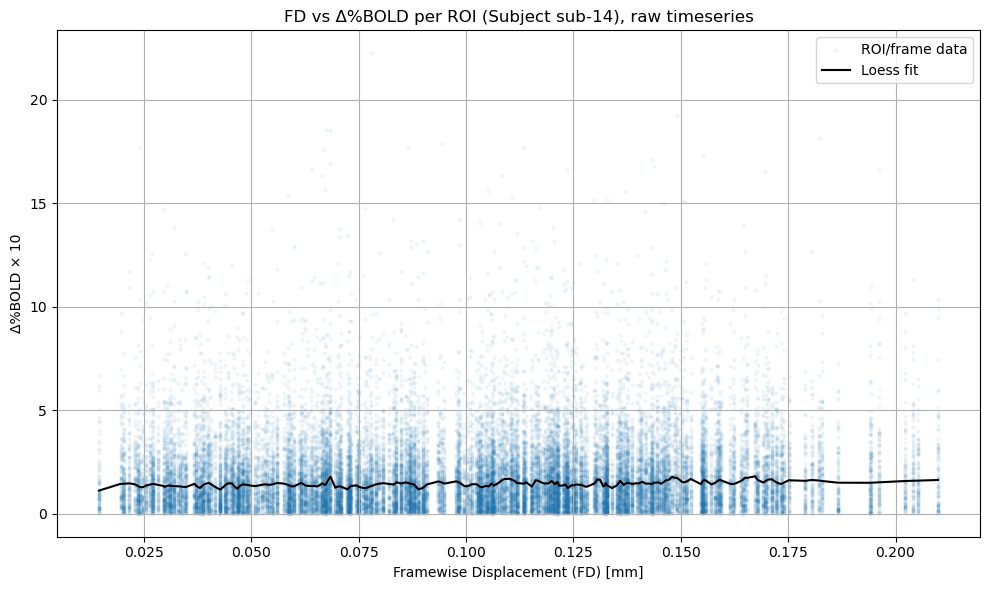

In [ ]:
#I used the rp_*.txt file from SPM in which we have 6 columns, with rotations in radians.

#compute Framewise Displacement (FD) 
def compute_fd_from_rp(rp_file, radius=50): #this values = 50 is from Power et al. 2012 paper
    motion = np.loadtxt(rp_file) # rp file from SPM, 6 motion parameters: x, y, z, rot_x, rot_y, rot_z
    diffs = np.diff(motion, axis=0) #frame-to-frame differences
    diffs[:, 3:6] *= radius #convert rotations from radians to mm using brain radius (50 from Power)
    fd = np.sum(np.abs(diffs), axis=1) #sum absolute motion across all params
    fd = np.insert(fd, 0, 0) # set FD[0] = 0 since there is no motion before first frame
    return fd

def load_timeseries(ts_file):
    raw_ts = np.loadtxt(ts_file)  # load raw time series
    mean_signal = np.mean(raw_ts, axis=0, keepdims=True)  # mean signal per ROI
    ts_percent = (raw_ts - mean_signal) / mean_signal * 100  # %BOLD
    return ts_percent


#compute smoothed FD-to-signal-change using LOESS (LOESS = Locally Estimated Scatterplot Smoothing)
def plot_fd_vs_per_roi_delta_percent_bold(fd, ts, subject_id):
    #temporal derivative of %BOLD (frame-to-frame signal change)
    diff = np.abs(np.diff(ts, axis=0)) * 10  # delta % BOLD × 10 
    fd = fd[1:] # exclude first FD value (no difference computed for it)
    fd_expanded = np.repeat(fd, diff.shape[1])  #repeat FD for each ROI (to match 2D structure of ROIs bold file)
    signal_change_flat = diff.flatten() #2D->1D
    loess_fit = lowess(signal_change_flat, fd_expanded, frac=0.02)

    plt.figure(figsize=(10, 6))
    plt.scatter(fd_expanded, signal_change_flat, alpha=0.05, s=4, label='ROI/frame data')
    plt.plot(loess_fit[:, 0], loess_fit[:, 1], color='black', label='Loess fit')
    plt.xlabel("Framewise Displacement (FD) [mm]")
    plt.ylabel("Δ%BOLD × 10")
    plt.title(f"FD vs Δ%BOLD per ROI (Subject {subject_id}), raw timeseries")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


subject = "sub-14"
ses = "ses-1"
base_path = "/Users/patrycjascislewska/Analizy_neuro/Graphs/DATA"

rp_file = os.path.join(base_path, ses, subject, "RS", "rp_RS_3x3x3_384dyn.txt")
ts_file = os.path.join(base_path, ses, subject, "Timeseries/data/wAALours/wAALours_ts_raw.txt")

# === RUN ===
ts_percent = load_timeseries(ts_file) 
fd = compute_fd_from_rp(rp_file)
plot_fd_vs_per_roi_delta_percent_bold(fd, ts_percent, subject_id=subject)


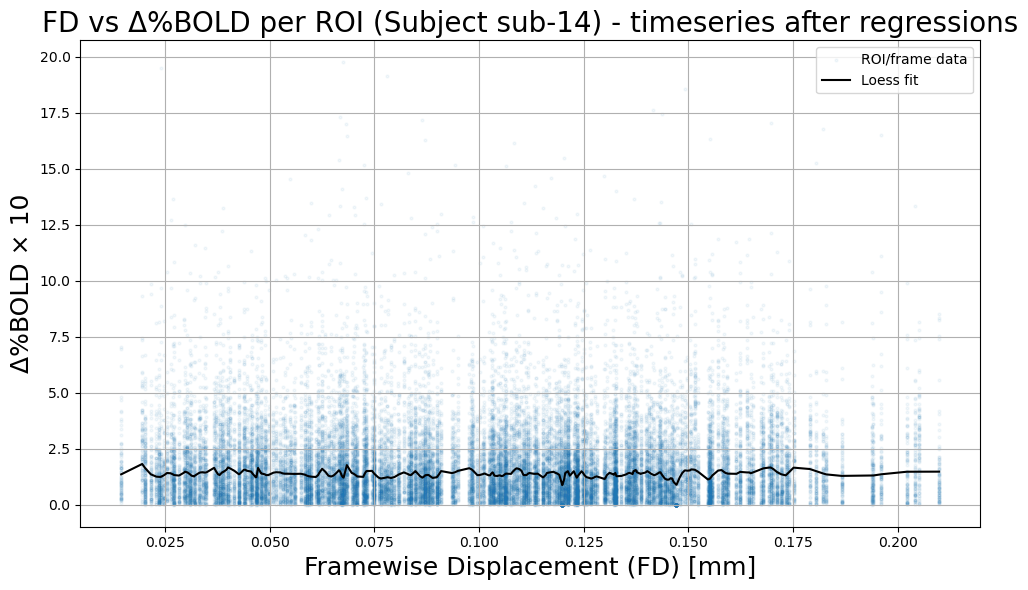

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess
import os

def compute_fd_from_rp(rp_file, radius=50):
    motion = np.loadtxt(rp_file)
    diffs = np.diff(motion, axis=0)
    diffs[:, 3:6] *= radius
    fd = np.sum(np.abs(diffs), axis=1)
    fd = np.insert(fd, 0, 0)
    return fd
#convert regressed time series to %BOLD signal change using raw baseline
def load_timeseries(regressed_ts_file, raw_ts_file):
    regressed_ts = np.loadtxt(regressed_ts_file)  #here we load motion-regressed time series 
    raw_ts = np.loadtxt(raw_ts_file)  #use RAW time series to compute a "valid" baseline (mean value per ROI)
    #mean signal per ROI from raw data
    mean_signal = np.mean(raw_ts, axis=0, keepdims=True)
    
    #very low means can destabilize %BOLD computation so the computation "exploads" to extremely high values, 
    # so I added warning
    if np.any(np.abs(mean_signal) < 1e-3):
        print("Warning: Some ROIs have near-zero mean in raw signal!")
    #compute %BOLD = (regressed - baseline) / baseline * 100
    ts_percent = (regressed_ts - mean_signal) / mean_signal * 100
    return ts_percent


def plot_fd_vs_per_roi_delta_percent_bold(fd, ts, subject_id):
    diff = np.abs(np.diff(ts, axis=0)) * 10  # Δ%BOLD × 10
    fd = fd[1:]

    fd_expanded = np.repeat(fd, diff.shape[1])
    signal_change_flat = diff.flatten()

    loess_fit = lowess(signal_change_flat, fd_expanded, frac=0.02)

    plt.figure(figsize=(10, 6))
    plt.scatter(fd_expanded, signal_change_flat, alpha=0.05, s=4, label='ROI/frame data')
    plt.plot(loess_fit[:, 0], loess_fit[:, 1], color='black', label='Loess fit')
    plt.xlabel("Framewise Displacement (FD) [mm]", fontsize = 18)
    plt.ylabel("Δ%BOLD × 10", fontsize = 18)
    plt.title(f"FD vs Δ%BOLD per ROI (Subject {subject_id}) - timeseries after regressions", fontsize = 20)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


subject = "sub-14"
ses = "ses-1"
base_path = "/Users/patrycjascislewska/Analizy_neuro/Graphs/DATA"

rp_file = os.path.join(base_path, ses, subject, "RS", "rp_RS_3x3x3_384dyn.txt")
ts_file = os.path.join(base_path, ses, subject, "Timeseries/data/wAALours/wAALours_ts.txt")
ts_raw_file = os.path.join(base_path, ses, subject, "Timeseries/data/wAALours/wAALours_ts_raw.txt")


# === RUN ===
ts = load_timeseries(ts_file, ts_raw_file)
fd = compute_fd_from_rp(rp_file)
plot_fd_vs_per_roi_delta_percent_bold(fd, ts, subject_id=subject)



Top subjects with highest Δ%BOLD × 10 values (possible outliers):
1. sub-28: max Δ%BOLD ×10 = 9.86
2. sub-33: max Δ%BOLD ×10 = 9.82
3. sub-08: max Δ%BOLD ×10 = 6.06
4. sub-18: max Δ%BOLD ×10 = 5.41
5. sub-27: max Δ%BOLD ×10 = 4.96

Top subjects with highest max Framewise Displacement (FD):
1. sub-28: max FD = 3.4959, mean FD = 0.1687
2. sub-18: max FD = 2.1534, mean FD = 0.2005
3. sub-33: max FD = 1.5697, mean FD = 0.0977
4. sub-06: max FD = 1.2227, mean FD = 0.1239
5. sub-19: max FD = 1.1039, mean FD = 0.1945


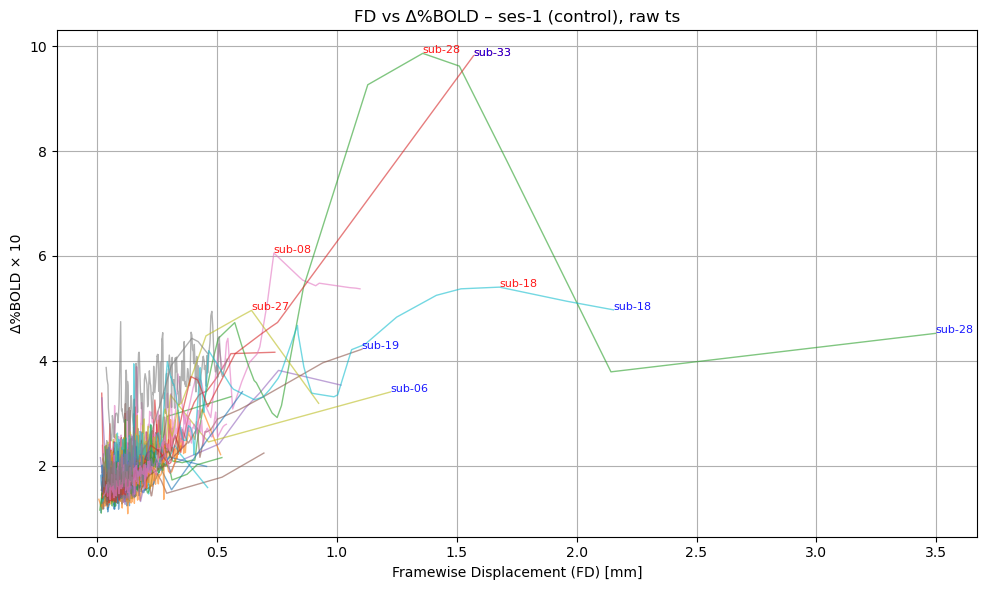

In [7]:
#compute Framewise Displacement (FD) 
def compute_fd_from_rp(rp_file, radius=50):
    motion = np.loadtxt(rp_file)  # rp file from SPM, 6 motion parameters: x, y, z, rot_x, rot_y, rot_z
    diffs = np.diff(motion, axis=0)  #frame-to-frame differences
    diffs[:, 3:6] *= radius  #convert rotations from radians to mm using brain radius
    fd = np.sum(np.abs(diffs), axis=1)  #sum absolute motion across all params
    fd = np.insert(fd, 0, 0)  # set FD[0] = 0 since there is no motion before first frame
    return fd


def load_timeseries_percent_bold(ts_file):
    ts = np.loadtxt(ts_file) #here we loas raw time series
    mean_signal = np.mean(ts, axis=0, keepdims=True) #mean signal per ROI from raw data
    ts_percent = (ts - mean_signal) / mean_signal * 100
    return ts_percent

#compute smoothed FD-to-signal-change using LOESS 
def compute_loess_curve(fd, ts_percent, frac=0.02):
    #temporal derivative of %BOLD (frame-to-frame signal change)
    diff = np.abs(np.diff(ts_percent, axis=0)) * 10
    fd = fd[1:]  # exclude first FD value (no difference computed for it)
    fd_expanded = np.repeat(fd, diff.shape[1])   #flatten matrices to match framewise structure and repeat FD for each ROI
    signal_change = diff.flatten()
    return lowess(signal_change, fd_expanded, frac=frac)


#main function to reproduce Power Fig 2B and highlight outliers
def replicate_power_fig2b_with_labels(subjects, ses, base_path, top_n=5):
    plt.figure(figsize=(10, 6))
    subject_curves = {} #here we keep smoothed LOESS curves for each subject
    fd_stats = {}  #here we keep FD metrics (max, mean) for each subject

    for subject in subjects:
        rp_file = os.path.join(base_path, ses, subject, "RS", "rp_RS_3x3x3_384dyn.txt")
        ts_file = os.path.join(base_path, ses, subject, "Timeseries/data/wAALours/wAALours_ts_raw.txt")

        #check if all required files exist
        if not os.path.exists(rp_file) or not os.path.exists(ts_file):
            print(f"Skipping {subject}: missing file(s).")
            continue

        try:
            #compute %BOLD
            ts_percent = load_timeseries_percent_bold(ts_file)

            #compute FD and LOESS curve
            fd = compute_fd_from_rp(rp_file)
            loess_curve = compute_loess_curve(fd, ts_percent)


            #store results for this subject
            subject_curves[subject] = loess_curve
            fd_stats[subject] = {
                'max_fd': np.max(fd),
                'mean_fd': np.mean(fd)
            }
            #plot curve for this subject    
            plt.plot(loess_curve[:, 0], loess_curve[:, 1], alpha=0.6, linewidth=1) #loess returns an array of shape [n_points, 2], 
            #where column [:, 0] is the x-values used in smoothing (in our case FD values) and column [:, 1] is the y-values from the smoothed fit (Δ%BOLD × 10)
        except Exception as e:
            print(f"Error processing {subject}: {e}")
            continue

            

    #identify and annotate top outliers by %BOLD
    sorted_by_bold = sorted(subject_curves.items(), key=lambda x: np.max(x[1][:, 1]), reverse=True)
    print("\nTop subjects with highest Δ%BOLD × 10 values (possible outliers):")
    for i, (sub, curve) in enumerate(sorted_by_bold[:top_n]):
        max_y = np.max(curve[:, 1])
        print(f"{i+1}. {sub}: max Δ%BOLD ×10 = {max_y:.2f}")
        x_label, y_label = curve[np.argmax(curve[:, 1])]
        plt.text(x_label, y_label, sub, fontsize=8, color='red', alpha=0.9)

    #identify and annotate top outliers by FD
    sorted_by_fd = sorted(fd_stats.items(), key=lambda x: x[1]['max_fd'], reverse=True)
    print("\nTop subjects with highest max Framewise Displacement (FD):")
    for i, (sub, stats) in enumerate(sorted_by_fd[:top_n]):
        print(f"{i+1}. {sub}: max FD = {stats['max_fd']:.4f}, mean FD = {stats['mean_fd']:.4f}")
        if sub in subject_curves:
            curve = subject_curves[sub]
            x_label, y_label = curve[np.argmax(curve[:, 0])] 
            plt.text(x_label, y_label, sub, fontsize=8, color='blue', alpha=0.9)

    #plot all together
    plt.xlabel("Framewise Displacement (FD) [mm]")
    plt.ylabel("Δ%BOLD × 10")
    plt.title("FD vs Δ%BOLD – ses-1 (control), raw ts")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# RUN ALL
ses = "ses-1"
base_path = "/Users/patrycjascislewska/Analizy_neuro/Graphs/DATA"
subject_paths = glob.glob(os.path.join(base_path, ses, "sub-*"))
subjects = [os.path.basename(path) for path in subject_paths]

replicate_power_fig2b_with_labels(subjects, ses, base_path, top_n=5)



Top subjects with highest Δ%BOLD × 10 values (possible outliers):
1. sub-20: max Δ%BOLD ×10 = 6.35
2. sub-27: max Δ%BOLD ×10 = 6.29
3. sub-08: max Δ%BOLD ×10 = 5.58
4. sub-19: max Δ%BOLD ×10 = 4.18
5. sub-18: max Δ%BOLD ×10 = 3.59

Top subjects with highest max Framewise Displacement (FD):
1. sub-28: max FD = 3.4959, mean FD = 0.1687
2. sub-18: max FD = 2.1534, mean FD = 0.2005
3. sub-33: max FD = 1.5697, mean FD = 0.0977
4. sub-06: max FD = 1.2227, mean FD = 0.1239
5. sub-19: max FD = 1.1039, mean FD = 0.1945


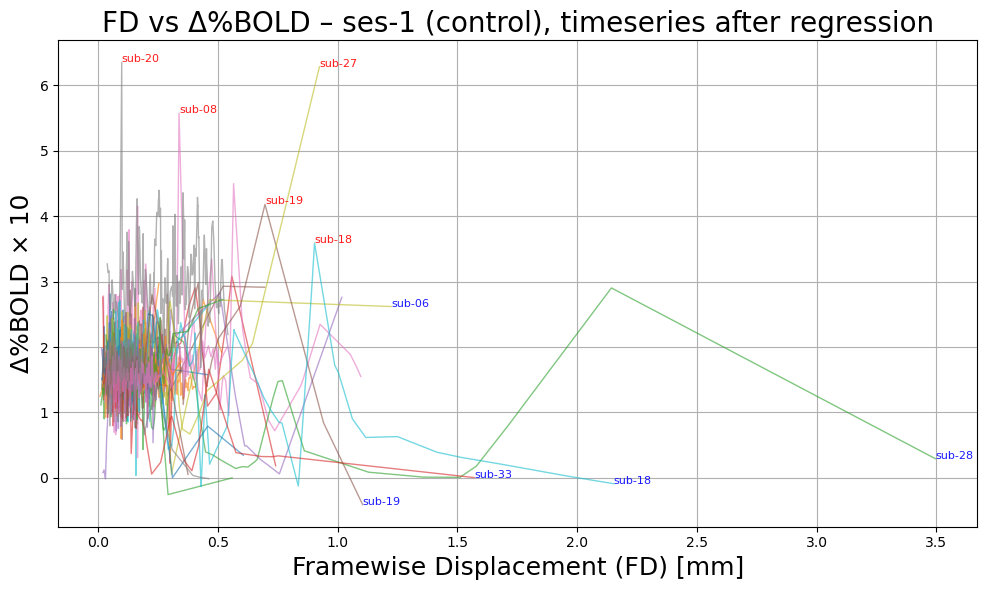

In [17]:
#compute Framewise Displacement (FD) 
def compute_fd_from_rp(rp_file, radius=50):
    motion = np.loadtxt(rp_file)  # rp file from SPM, 6 motion parameters: x, y, z, rot_x, rot_y, rot_z
    diffs = np.diff(motion, axis=0)  #frame-to-frame differences
    diffs[:, 3:6] *= radius  #convert rotations from radians to mm using brain radius
    fd = np.sum(np.abs(diffs), axis=1)  #sum absolute motion across all params
    fd = np.insert(fd, 0, 0)  # set FD[0] = 0 since there is no motion before first frame
    return fd

#convert regressed time series to %BOLD signal change using raw baseline
def load_timeseries_percent_bold(regressed_ts_file, raw_ts_file):
    regressed_ts = np.loadtxt(regressed_ts_file) #here we load motion-regressed time series 
    raw_ts = np.loadtxt(raw_ts_file)        #use RAW time series to compute a "valid" baseline (mean value per ROI)

    #mean signal per ROI from raw data
    mean_signal = np.mean(raw_ts, axis=0, keepdims=True)

    #very low means can destabilize %BOLD computation so the computation "exploads" to extremely high values, so I added warning
    if np.any(np.abs(mean_signal) < 1e-3):
        print("Warning: Some ROIs have near-zero mean in raw signal!")

    #compute %BOLD = (regressed - baseline) / baseline * 100
    ts_percent = (regressed_ts - mean_signal) / mean_signal * 100
    return ts_percent

#compute smoothed FD-to-signal-change using LOESS 
def compute_loess_curve(fd, ts_percent, frac=0.02):
    #temporal derivative of %BOLD (frame-to-frame signal change)
    diff = np.abs(np.diff(ts_percent, axis=0)) * 10  # scaled for visibility
    fd = fd[1:]  # exclude first FD value (no difference computed for it)

    #flatten matrices to match framewise structure
    fd_expanded = np.repeat(fd, diff.shape[1])  # repeat FD for each ROI
    signal_change = diff.flatten()

    #apply locally weighted regression (LOWESS)
    return lowess(signal_change, fd_expanded, frac=frac)

#main function to reproduce Power Fig 2B and highlight outliers
def replicate_power_fig2b_with_labels(subjects, ses, base_path, top_n=5):
    plt.figure(figsize=(10, 6))
    subject_curves = {}  #here we keep smoothed LOESS curves for each subject
    fd_stats = {}  #here we keep FD metrics (max, mean) for each subject

    for subject in subjects:
        rp_file = os.path.join(base_path, ses, subject, "RS", "rp_RS_3x3x3_384dyn.txt")
        ts_file = os.path.join(base_path, ses, subject, "Timeseries/data/wAALours/wAALours_ts.txt")  # regressed
        ts_raw_file = os.path.join(base_path, ses, subject, "Timeseries/data/wAALours/wAALours_ts_raw.txt")  # raw

        #check if all required files exist
        if not os.path.exists(rp_file) or not os.path.exists(ts_file) or not os.path.exists(ts_raw_file):
            print(f"Skipping {subject}: missing file(s).")
            continue

        try:
            #compute %BOLD relative to raw baseline
            ts_percent = load_timeseries_percent_bold(ts_file, ts_raw_file)

            #compute FD and LOESS curve
            fd = compute_fd_from_rp(rp_file)
            loess_curve = compute_loess_curve(fd, ts_percent)

            #store results for this subject
            subject_curves[subject] = loess_curve
            fd_stats[subject] = {
                'max_fd': np.max(fd),
                'mean_fd': np.mean(fd)
            }

            #plot curve for this subject
            plt.plot(loess_curve[:, 0], loess_curve[:, 1], alpha=0.6, linewidth=1)

        except Exception as e:
            print(f"Error processing {subject}: {e}")
            continue

    #identify and annotate top outliers by %BOLD
    sorted_by_bold = sorted(subject_curves.items(), key=lambda x: np.max(x[1][:, 1]), reverse=True)
    print("\nTop subjects with highest Δ%BOLD × 10 values (possible outliers):")
    for i, (sub, curve) in enumerate(sorted_by_bold[:top_n]):
        max_y = np.max(curve[:, 1])
        print(f"{i+1}. {sub}: max Δ%BOLD ×10 = {max_y:.2f}")
        x_label, y_label = curve[np.argmax(curve[:, 1])]
        plt.text(x_label, y_label, sub, fontsize=8, color='red', alpha=0.9)

    #identify and annotate top outliers by FD
    sorted_by_fd = sorted(fd_stats.items(), key=lambda x: x[1]['max_fd'], reverse=True)
    print("\nTop subjects with highest max Framewise Displacement (FD):")
    for i, (sub, stats) in enumerate(sorted_by_fd[:top_n]):
        print(f"{i+1}. {sub}: max FD = {stats['max_fd']:.4f}, mean FD = {stats['mean_fd']:.4f}")
        if sub in subject_curves:
            curve = subject_curves[sub]
            x_label, y_label = curve[np.argmax(curve[:, 0])]  # label at highest FD
            plt.text(x_label, y_label, sub, fontsize=8, color='blue', alpha=0.9)

    #plot all together
    plt.xlabel("Framewise Displacement (FD) [mm]", fontsize=18)
    plt.ylabel("Δ%BOLD × 10", fontsize=18)
    plt.title("FD vs Δ%BOLD – ses-1 (control), timeseries after regression", fontsize=20)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# RUN ALL
ses = "ses-1"
base_path = "/Users/patrycjascislewska/Analizy_neuro/Graphs/DATA"
subject_paths = glob.glob(os.path.join(base_path, ses, "sub-*"))  
subjects = [os.path.basename(path) for path in subject_paths]  

replicate_power_fig2b_with_labels(subjects, ses, base_path, top_n=5)



Top subjects with highest Δ%BOLD × 10 values (possible outliers):
1. sub-18: max Δ%BOLD ×10 = 40.14
2. sub-12: max Δ%BOLD ×10 = 29.54
3. sub-28: max Δ%BOLD ×10 = 27.83
4. sub-32: max Δ%BOLD ×10 = 21.37
5. sub-27: max Δ%BOLD ×10 = 12.31

Top subjects with highest max Framewise Displacement (FD):
1. sub-18: max FD = 9.5198, mean FD = 0.1974
2. sub-12: max FD = 4.2660, mean FD = 0.4176
3. sub-08: max FD = 1.5578, mean FD = 0.1579
4. sub-25: max FD = 1.5164, mean FD = 0.3554
5. sub-30: max FD = 1.4573, mean FD = 0.2137


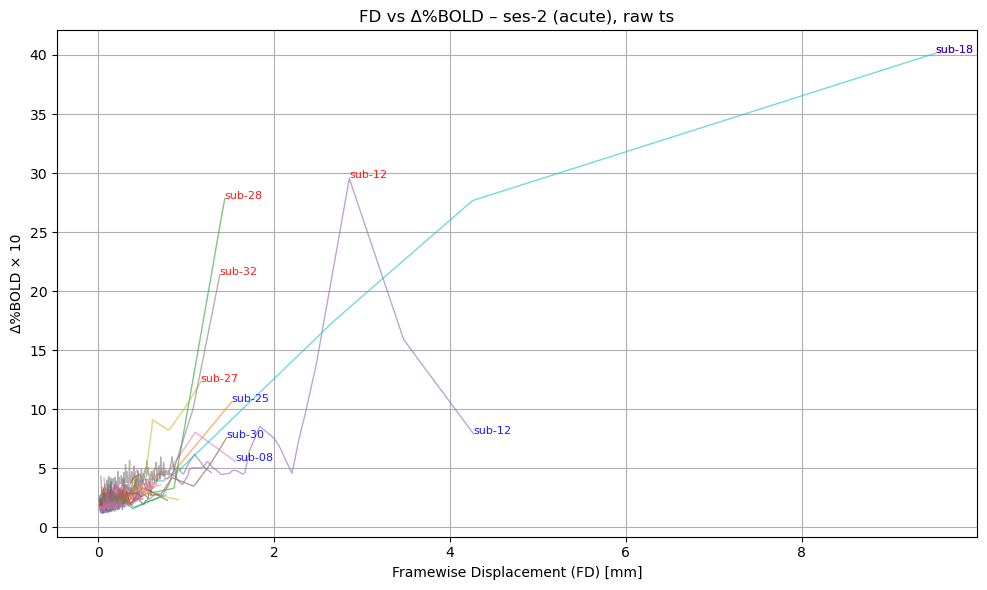

In [9]:
#compute Framewise Displacement (FD) 
def compute_fd_from_rp(rp_file, radius=50):
    motion = np.loadtxt(rp_file)  # rp file from SPM, 6 motion parameters: x, y, z, rot_x, rot_y, rot_z
    diffs = np.diff(motion, axis=0)  #frame-to-frame differences
    diffs[:, 3:6] *= radius  #convert rotations from radians to mm using brain radius
    fd = np.sum(np.abs(diffs), axis=1)  #sum absolute motion across all params
    fd = np.insert(fd, 0, 0)  # set FD[0] = 0 since there is no motion before first frame
    return fd


def load_timeseries_percent_bold(ts_file):
    ts = np.loadtxt(ts_file) #here we loas raw time series
    mean_signal = np.mean(ts, axis=0, keepdims=True) #mean signal per ROI from raw data
    ts_percent = (ts - mean_signal) / mean_signal * 100
    return ts_percent

#compute smoothed FD-to-signal-change using LOESS 
def compute_loess_curve(fd, ts_percent, frac=0.02):
    #temporal derivative of %BOLD (frame-to-frame signal change)
    diff = np.abs(np.diff(ts_percent, axis=0)) * 10
    fd = fd[1:]  # exclude first FD value (no difference computed for it)
    fd_expanded = np.repeat(fd, diff.shape[1])   #flatten matrices to match framewise structure and repeat FD for each ROI
    signal_change = diff.flatten()
    return lowess(signal_change, fd_expanded, frac=frac)



#main function to reproduce Power Fig 2B and highlight outliers
def replicate_power_fig2b_with_labels(subjects, ses, base_path, top_n=5):
    plt.figure(figsize=(10, 6))
    subject_curves = {} #here we keep smoothed LOESS curves for each subject
    fd_stats = {}  #here we keep FD metrics (max, mean) for each subject

    for subject in subjects:
        rp_file = os.path.join(base_path, ses, subject, "RS", "rp_RS_3x3x3_384dyn.txt")
        ts_file = os.path.join(base_path, ses, subject, "Timeseries/data/wAALours/wAALours_ts_raw.txt")

        #check if all required files exist
        if not os.path.exists(rp_file) or not os.path.exists(ts_file):
            print(f"Skipping {subject}: missing file(s).")
            continue

        try:
            #compute %BOLD
            ts_percent = load_timeseries_percent_bold(ts_file)

            #compute FD and LOESS curve
            fd = compute_fd_from_rp(rp_file)
            loess_curve = compute_loess_curve(fd, ts_percent)


            #store results for this subject
            subject_curves[subject] = loess_curve
            fd_stats[subject] = {
                'max_fd': np.max(fd),
                'mean_fd': np.mean(fd)
            }
            #plot curve for this subject    
            plt.plot(loess_curve[:, 0], loess_curve[:, 1], alpha=0.6, linewidth=1)
        except Exception as e:
            print(f"Error processing {subject}: {e}")
            continue

            

    #identify and annotate top outliers by %BOLD
    sorted_by_bold = sorted(subject_curves.items(), key=lambda x: np.max(x[1][:, 1]), reverse=True)
    print("\nTop subjects with highest Δ%BOLD × 10 values (possible outliers):")
    for i, (sub, curve) in enumerate(sorted_by_bold[:top_n]):
        max_y = np.max(curve[:, 1])
        print(f"{i+1}. {sub}: max Δ%BOLD ×10 = {max_y:.2f}")
        x_label, y_label = curve[np.argmax(curve[:, 1])]
        plt.text(x_label, y_label, sub, fontsize=8, color='red', alpha=0.9)

    #identify and annotate top outliers by FD
    sorted_by_fd = sorted(fd_stats.items(), key=lambda x: x[1]['max_fd'], reverse=True)
    print("\nTop subjects with highest max Framewise Displacement (FD):")
    for i, (sub, stats) in enumerate(sorted_by_fd[:top_n]):
        print(f"{i+1}. {sub}: max FD = {stats['max_fd']:.4f}, mean FD = {stats['mean_fd']:.4f}")
        if sub in subject_curves:
            curve = subject_curves[sub]
            x_label, y_label = curve[np.argmax(curve[:, 0])]
            plt.text(x_label, y_label, sub, fontsize=8, color='blue', alpha=0.9)

    #plot all together
    plt.xlabel("Framewise Displacement (FD) [mm]")
    plt.ylabel("Δ%BOLD × 10")
    plt.title("FD vs Δ%BOLD – ses-2 (acute), raw ts")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# RUN ALL
ses = "ses-2"
base_path = "/Users/patrycjascislewska/Analizy_neuro/Graphs/DATA"
subject_paths = glob.glob(os.path.join(base_path, ses, "sub-*"))
subjects = [os.path.basename(path) for path in subject_paths]

replicate_power_fig2b_with_labels(subjects, ses, base_path, top_n=5)



Top subjects with highest Δ%BOLD × 10 values (possible outliers):
1. sub-08: max Δ%BOLD ×10 = 11.19
2. sub-31: max Δ%BOLD ×10 = 8.16
3. sub-28: max Δ%BOLD ×10 = 7.81
4. sub-14: max Δ%BOLD ×10 = 6.41
5. sub-12: max Δ%BOLD ×10 = 5.65

Top subjects with highest max Framewise Displacement (FD):
1. sub-18: max FD = 9.5198, mean FD = 0.1974
2. sub-12: max FD = 4.2660, mean FD = 0.4176
3. sub-08: max FD = 1.5578, mean FD = 0.1579
4. sub-25: max FD = 1.5164, mean FD = 0.3554
5. sub-30: max FD = 1.4573, mean FD = 0.2137


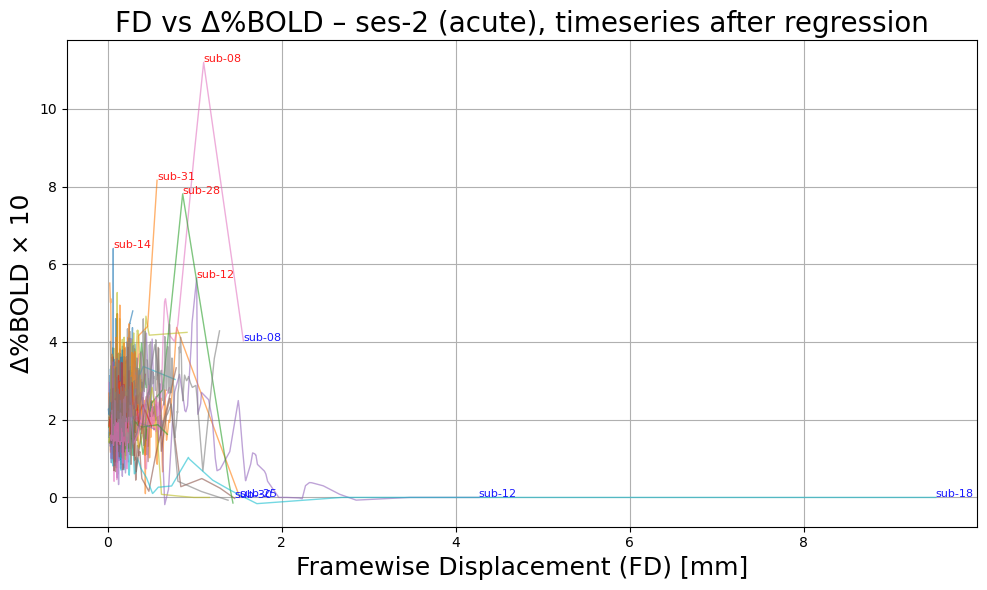

In [18]:
#compute Framewise Displacement (FD) 
def compute_fd_from_rp(rp_file, radius=50):
    motion = np.loadtxt(rp_file)  # rp file from SPM, 6 motion parameters: x, y, z, rot_x, rot_y, rot_z
    diffs = np.diff(motion, axis=0)  #frame-to-frame differences
    diffs[:, 3:6] *= radius  #convert rotations from radians to mm using brain radius
    fd = np.sum(np.abs(diffs), axis=1)  #sum absolute motion across all params
    fd = np.insert(fd, 0, 0)  # set FD[0] = 0 since there is no motion before first frame
    return fd

#convert regressed time series to %BOLD signal change using raw baseline
def load_timeseries_percent_bold(regressed_ts_file, raw_ts_file):
    regressed_ts = np.loadtxt(regressed_ts_file) #here we load motion-regressed time series 
    raw_ts = np.loadtxt(raw_ts_file)        #use RAW time series to compute a "valid" baseline (mean value per ROI)

    #mean signal per ROI from raw data
    mean_signal = np.mean(raw_ts, axis=0, keepdims=True)

    #very low means can destabilize %BOLD computation so the computation "exploads" to extremely high values, so I added warning
    if np.any(np.abs(mean_signal) < 1e-3):
        print("Warning: Some ROIs have near-zero mean in raw signal!")

    #compute %BOLD = (regressed - baseline) / baseline * 100
    ts_percent = (regressed_ts - mean_signal) / mean_signal * 100
    return ts_percent

#compute smoothed FD-to-signal-change using LOESS 
def compute_loess_curve(fd, ts_percent, frac=0.02):
    #temporal derivative of %BOLD (frame-to-frame signal change)
    diff = np.abs(np.diff(ts_percent, axis=0)) * 10  # scaled for visibility
    fd = fd[1:]  # exclude first FD value (no difference computed for it)

    #flatten matrices to match framewise structure
    fd_expanded = np.repeat(fd, diff.shape[1])  # repeat FD for each ROI
    signal_change = diff.flatten()

    #apply locally weighted regression (LOWESS)
    return lowess(signal_change, fd_expanded, frac=frac)

#main function to reproduce Power Fig 2B and highlight outliers
def replicate_power_fig2b_with_labels(subjects, ses, base_path, top_n=5):
    plt.figure(figsize=(10, 6))
    subject_curves = {}  #here we keep smoothed LOESS curves for each subject
    fd_stats = {}  #here we keep FD metrics (max, mean) for each subject

    for subject in subjects:
        rp_file = os.path.join(base_path, ses, subject, "RS", "rp_RS_3x3x3_384dyn.txt")
        ts_file = os.path.join(base_path, ses, subject, "Timeseries/data/wAALours/wAALours_ts.txt")  # regressed
        ts_raw_file = os.path.join(base_path, ses, subject, "Timeseries/data/wAALours/wAALours_ts_raw.txt")  # raw

        #check if all required files exist
        if not os.path.exists(rp_file) or not os.path.exists(ts_file) or not os.path.exists(ts_raw_file):
            print(f"Skipping {subject}: missing file(s).")
            continue

        try:
            #compute %BOLD relative to raw baseline
            ts_percent = load_timeseries_percent_bold(ts_file, ts_raw_file)

            #compute FD and LOESS curve
            fd = compute_fd_from_rp(rp_file)
            loess_curve = compute_loess_curve(fd, ts_percent)

            #store results for this subject
            subject_curves[subject] = loess_curve
            fd_stats[subject] = {
                'max_fd': np.max(fd),
                'mean_fd': np.mean(fd)
            }

            #plot curve for this subject
            plt.plot(loess_curve[:, 0], loess_curve[:, 1], alpha=0.6, linewidth=1)

        except Exception as e:
            print(f"Error processing {subject}: {e}")
            continue

    #identify and annotate top outliers by %BOLD
    sorted_by_bold = sorted(subject_curves.items(), key=lambda x: np.max(x[1][:, 1]), reverse=True)
    print("\nTop subjects with highest Δ%BOLD × 10 values (possible outliers):")
    for i, (sub, curve) in enumerate(sorted_by_bold[:top_n]):
        max_y = np.max(curve[:, 1])
        print(f"{i+1}. {sub}: max Δ%BOLD ×10 = {max_y:.2f}")
        x_label, y_label = curve[np.argmax(curve[:, 1])]
        plt.text(x_label, y_label, sub, fontsize=8, color='red', alpha=0.9)

    #identify and annotate top outliers by FD
    sorted_by_fd = sorted(fd_stats.items(), key=lambda x: x[1]['max_fd'], reverse=True)
    print("\nTop subjects with highest max Framewise Displacement (FD):")
    for i, (sub, stats) in enumerate(sorted_by_fd[:top_n]):
        print(f"{i+1}. {sub}: max FD = {stats['max_fd']:.4f}, mean FD = {stats['mean_fd']:.4f}")
        if sub in subject_curves:
            curve = subject_curves[sub]
            x_label, y_label = curve[np.argmax(curve[:, 0])]  # label at highest FD
            plt.text(x_label, y_label, sub, fontsize=8, color='blue', alpha=0.9)

    #plot all together
    plt.xlabel("Framewise Displacement (FD) [mm]", fontsize=18)
    plt.ylabel("Δ%BOLD × 10", fontsize=18)
    plt.title("FD vs Δ%BOLD – ses-2 (acute), timeseries after regression", fontsize=20)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# RUN ALL
ses = "ses-2"
base_path = "/Users/patrycjascislewska/Analizy_neuro/Graphs/DATA"
subject_paths = glob.glob(os.path.join(base_path, ses, "sub-*"))  
subjects = [os.path.basename(path) for path in subject_paths]  

replicate_power_fig2b_with_labels(subjects, ses, base_path, top_n=5)



Top subjects with highest Δ%BOLD × 10 values (possible outliers):
1. sub-30: max Δ%BOLD ×10 = 50.44
2. sub-12: max Δ%BOLD ×10 = 15.45
3. sub-28: max Δ%BOLD ×10 = 14.54
4. sub-10: max Δ%BOLD ×10 = 6.92
5. sub-02: max Δ%BOLD ×10 = 6.89

Top subjects with highest max Framewise Displacement (FD):
1. sub-30: max FD = 5.2977, mean FD = 0.1676
2. sub-21: max FD = 2.4447, mean FD = 0.2729
3. sub-12: max FD = 2.2728, mean FD = 0.2062
4. sub-28: max FD = 1.6338, mean FD = 0.1394
5. sub-18: max FD = 1.3214, mean FD = 0.1063


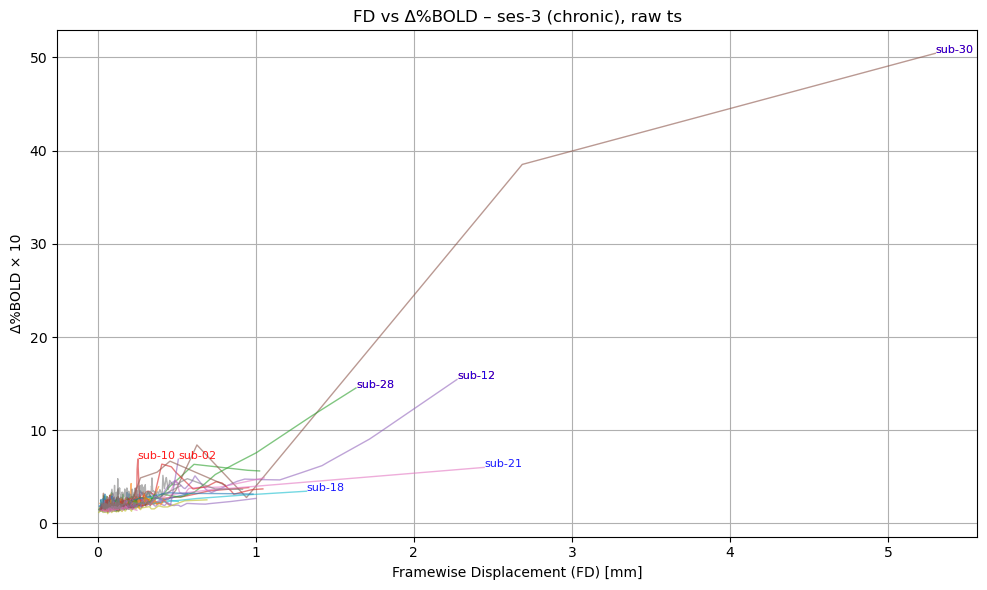

In [11]:
#compute Framewise Displacement (FD) 
def compute_fd_from_rp(rp_file, radius=50):
    motion = np.loadtxt(rp_file)  # rp file from SPM, 6 motion parameters: x, y, z, rot_x, rot_y, rot_z
    diffs = np.diff(motion, axis=0)  #frame-to-frame differences
    diffs[:, 3:6] *= radius  #convert rotations from radians to mm using brain radius
    fd = np.sum(np.abs(diffs), axis=1)  #sum absolute motion across all params
    fd = np.insert(fd, 0, 0)  # set FD[0] = 0 since there is no motion before first frame
    return fd


def load_timeseries_percent_bold(ts_file):
    ts = np.loadtxt(ts_file) #here we loas raw time series
    mean_signal = np.mean(ts, axis=0, keepdims=True) #mean signal per ROI from raw data
    ts_percent = (ts - mean_signal) / mean_signal * 100
    return ts_percent

#compute smoothed FD-to-signal-change using LOESS 
def compute_loess_curve(fd, ts_percent, frac=0.02):
    #temporal derivative of %BOLD (frame-to-frame signal change)
    diff = np.abs(np.diff(ts_percent, axis=0)) * 10
    fd = fd[1:]  # exclude first FD value (no difference computed for it)
    fd_expanded = np.repeat(fd, diff.shape[1])   #flatten matrices to match framewise structure and repeat FD for each ROI
    signal_change = diff.flatten()
    return lowess(signal_change, fd_expanded, frac=frac)



#main function to reproduce Power Fig 2B and highlight outliers
def replicate_power_fig2b_with_labels(subjects, ses, base_path, top_n=5):
    plt.figure(figsize=(10, 6))
    subject_curves = {} #here we keep smoothed LOESS curves for each subject
    fd_stats = {}  #here we keep FD metrics (max, mean) for each subject

    for subject in subjects:
        rp_file = os.path.join(base_path, ses, subject, "RS", "rp_RS_3x3x3_384dyn.txt")
        ts_file = os.path.join(base_path, ses, subject, "Timeseries/data/wAALours/wAALours_ts_raw.txt")

        #check if all required files exist
        if not os.path.exists(rp_file) or not os.path.exists(ts_file):
            print(f"Skipping {subject}: missing file(s).")
            continue

        try:
            #compute %BOLD
            ts_percent = load_timeseries_percent_bold(ts_file)

            #compute FD and LOESS curve
            fd = compute_fd_from_rp(rp_file)
            loess_curve = compute_loess_curve(fd, ts_percent)


            #store results for this subject
            subject_curves[subject] = loess_curve
            fd_stats[subject] = {
                'max_fd': np.max(fd),
                'mean_fd': np.mean(fd)
            }
            #plot curve for this subject    
            plt.plot(loess_curve[:, 0], loess_curve[:, 1], alpha=0.6, linewidth=1)
        except Exception as e:
            print(f"Error processing {subject}: {e}")
            continue

            

    #identify and annotate top outliers by %BOLD
    sorted_by_bold = sorted(subject_curves.items(), key=lambda x: np.max(x[1][:, 1]), reverse=True)
    print("\nTop subjects with highest Δ%BOLD × 10 values (possible outliers):")
    for i, (sub, curve) in enumerate(sorted_by_bold[:top_n]):
        max_y = np.max(curve[:, 1])
        print(f"{i+1}. {sub}: max Δ%BOLD ×10 = {max_y:.2f}")
        x_label, y_label = curve[np.argmax(curve[:, 1])]
        plt.text(x_label, y_label, sub, fontsize=8, color='red', alpha=0.9)

    #identify and annotate top outliers by FD
    sorted_by_fd = sorted(fd_stats.items(), key=lambda x: x[1]['max_fd'], reverse=True)
    print("\nTop subjects with highest max Framewise Displacement (FD):")
    for i, (sub, stats) in enumerate(sorted_by_fd[:top_n]):
        print(f"{i+1}. {sub}: max FD = {stats['max_fd']:.4f}, mean FD = {stats['mean_fd']:.4f}")
        if sub in subject_curves:
            curve = subject_curves[sub]
            x_label, y_label = curve[np.argmax(curve[:, 0])]
            plt.text(x_label, y_label, sub, fontsize=8, color='blue', alpha=0.9)

    #plot all together
    plt.xlabel("Framewise Displacement (FD) [mm]")
    plt.ylabel("Δ%BOLD × 10")
    plt.title("FD vs Δ%BOLD – ses-3 (chronic), raw ts")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# RUN ALL
ses = "ses-3"
base_path = "/Users/patrycjascislewska/Analizy_neuro/Graphs/DATA"
subject_paths = glob.glob(os.path.join(base_path, ses, "sub-*"))
subjects = [os.path.basename(path) for path in subject_paths]

replicate_power_fig2b_with_labels(subjects, ses, base_path, top_n=5)



Top subjects with highest Δ%BOLD × 10 values (possible outliers):
1. sub-03: max Δ%BOLD ×10 = 7.05
2. sub-23: max Δ%BOLD ×10 = 5.40
3. sub-14: max Δ%BOLD ×10 = 4.92
4. sub-20: max Δ%BOLD ×10 = 4.87
5. sub-10: max Δ%BOLD ×10 = 4.21

Top subjects with highest max Framewise Displacement (FD):
1. sub-30: max FD = 5.2977, mean FD = 0.1676
2. sub-21: max FD = 2.4447, mean FD = 0.2729
3. sub-12: max FD = 2.2728, mean FD = 0.2062
4. sub-28: max FD = 1.6338, mean FD = 0.1394
5. sub-18: max FD = 1.3214, mean FD = 0.1063


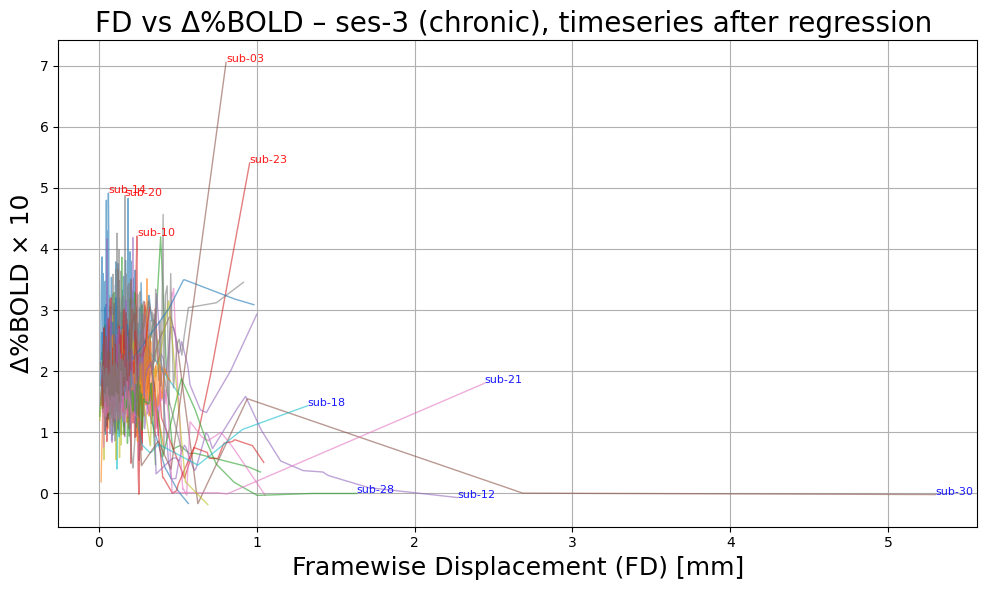

In [19]:
#compute Framewise Displacement (FD) 
def compute_fd_from_rp(rp_file, radius=50):
    motion = np.loadtxt(rp_file)  # rp file from SPM, 6 motion parameters: x, y, z, rot_x, rot_y, rot_z
    diffs = np.diff(motion, axis=0)  #frame-to-frame differences
    diffs[:, 3:6] *= radius  #convert rotations from radians to mm using brain radius
    fd = np.sum(np.abs(diffs), axis=1)  #sum absolute motion across all params
    fd = np.insert(fd, 0, 0)  # set FD[0] = 0 since there is no motion before first frame
    return fd

#convert regressed time series to %BOLD signal change using raw baseline
def load_timeseries_percent_bold(regressed_ts_file, raw_ts_file):
    regressed_ts = np.loadtxt(regressed_ts_file) #here we load motion-regressed time series 
    raw_ts = np.loadtxt(raw_ts_file)        #use RAW time series to compute a "valid" baseline (mean value per ROI)

    #mean signal per ROI from raw data
    mean_signal = np.mean(raw_ts, axis=0, keepdims=True)

    #very low means can destabilize %BOLD computation so the computation "exploads" to extremely high values, so I added warning
    if np.any(np.abs(mean_signal) < 1e-3):
        print("Warning: Some ROIs have near-zero mean in raw signal!")

    #compute %BOLD = (regressed - baseline) / baseline * 100
    ts_percent = (regressed_ts - mean_signal) / mean_signal * 100
    return ts_percent

#compute smoothed FD-to-signal-change using LOESS 
def compute_loess_curve(fd, ts_percent, frac=0.02):
    #temporal derivative of %BOLD (frame-to-frame signal change)
    diff = np.abs(np.diff(ts_percent, axis=0)) * 10  # scaled for visibility
    fd = fd[1:]  # exclude first FD value (no difference computed for it)

    #flatten matrices to match framewise structure
    fd_expanded = np.repeat(fd, diff.shape[1])  # repeat FD for each ROI
    signal_change = diff.flatten()

    #apply locally weighted regression (LOWESS)
    return lowess(signal_change, fd_expanded, frac=frac)

#main function to reproduce Power Fig 2B and highlight outliers
def replicate_power_fig2b_with_labels(subjects, ses, base_path, top_n=5):
    plt.figure(figsize=(10, 6))
    subject_curves = {}  #here we keep smoothed LOESS curves for each subject
    fd_stats = {}  #here we keep FD metrics (max, mean) for each subject

    for subject in subjects:
        rp_file = os.path.join(base_path, ses, subject, "RS", "rp_RS_3x3x3_384dyn.txt")
        ts_file = os.path.join(base_path, ses, subject, "Timeseries/data/wAALours/wAALours_ts.txt")  # regressed
        ts_raw_file = os.path.join(base_path, ses, subject, "Timeseries/data/wAALours/wAALours_ts_raw.txt")  # raw

        #check if all required files exist
        if not os.path.exists(rp_file) or not os.path.exists(ts_file) or not os.path.exists(ts_raw_file):
            print(f"Skipping {subject}: missing file(s).")
            continue

        try:
            #compute %BOLD relative to raw baseline
            ts_percent = load_timeseries_percent_bold(ts_file, ts_raw_file)

            #compute FD and LOESS curve
            fd = compute_fd_from_rp(rp_file)
            loess_curve = compute_loess_curve(fd, ts_percent)

            #store results for this subject
            subject_curves[subject] = loess_curve
            fd_stats[subject] = {
                'max_fd': np.max(fd),
                'mean_fd': np.mean(fd)
            }

            #plot curve for this subject
            plt.plot(loess_curve[:, 0], loess_curve[:, 1], alpha=0.6, linewidth=1)

        except Exception as e:
            print(f"Error processing {subject}: {e}")
            continue

    #identify and annotate top outliers by %BOLD
    sorted_by_bold = sorted(subject_curves.items(), key=lambda x: np.max(x[1][:, 1]), reverse=True)
    print("\nTop subjects with highest Δ%BOLD × 10 values (possible outliers):")
    for i, (sub, curve) in enumerate(sorted_by_bold[:top_n]):
        max_y = np.max(curve[:, 1])
        print(f"{i+1}. {sub}: max Δ%BOLD ×10 = {max_y:.2f}")
        x_label, y_label = curve[np.argmax(curve[:, 1])]
        plt.text(x_label, y_label, sub, fontsize=8, color='red', alpha=0.9)

    #identify and annotate top outliers by FD
    sorted_by_fd = sorted(fd_stats.items(), key=lambda x: x[1]['max_fd'], reverse=True)
    print("\nTop subjects with highest max Framewise Displacement (FD):")
    for i, (sub, stats) in enumerate(sorted_by_fd[:top_n]):
        print(f"{i+1}. {sub}: max FD = {stats['max_fd']:.4f}, mean FD = {stats['mean_fd']:.4f}")
        if sub in subject_curves:
            curve = subject_curves[sub]
            x_label, y_label = curve[np.argmax(curve[:, 0])]  # label at highest FD
            plt.text(x_label, y_label, sub, fontsize=8, color='blue', alpha=0.9)

    #plot all together
    plt.xlabel("Framewise Displacement (FD) [mm]", fontsize=18)
    plt.ylabel("Δ%BOLD × 10", fontsize=18)
    plt.title("FD vs Δ%BOLD – ses-3 (chronic), timeseries after regression ", fontsize=20)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# RUN ALL
ses = "ses-3"
base_path = "/Users/patrycjascislewska/Analizy_neuro/Graphs/DATA"
subject_paths = glob.glob(os.path.join(base_path, ses, "sub-*"))  
subjects = [os.path.basename(path) for path in subject_paths]  

replicate_power_fig2b_with_labels(subjects, ses, base_path, top_n=5)
